## Brain Networks as a Multiplex Structure
### Jeremy Kazimer
### Dane Taylor
### 6/15/2021

#### _Import Statements_

In [1]:
# Data structures
import numpy as np
import pandas as pds
import scipy.io

# System and utility
import os, sys
sys.path.append('utility')

from graphs_util import *
from VNE_util import *

# Plots and graphs
from matplotlib import pyplot as plt
from matplotlib import colors as cm

#### _Get a Network_

We begin by fetching a network relating to a brain network by frequency such that its divided into 7 bands: $\alpha_1$, $\alpha_2$, $\theta$, $\delta$, $\beta_1$, $\beta_2$, and $\gamma$.  In total, there are 25 brains for a healthy person (HC) and somebody with Alzheimer's (AD).  If we ignore AD, then there are 25 * 7 total networks.  However, we will choose to run with $\theta$ and $\delta$, since they are adjacent to each other without composing the same frequency band.  

Note that there are also separations between male (M) and female (F), but we're also not concerned with this.

In [2]:
brains = scipy.io.loadmat('data/brain.mat')

In [3]:
brains['frequencyBands']

array([[(array(['\\delta'], dtype='<U6'), array([[2, 4]], dtype=uint8)),
        (array(['\\theta'], dtype='<U6'), array([[4, 8]], dtype=uint8)),
        (array(['\\alpha_{1}'], dtype='<U10'), array([[ 8. , 10.5]])),
        (array(['\\alpha_{2}'], dtype='<U10'), array([[10.5, 13. ]])),
        (array(['\\beta_{1}'], dtype='<U9'), array([[13, 20]], dtype=uint8)),
        (array(['\\beta_{2}'], dtype='<U9'), array([[20, 30]], dtype=uint8)),
        (array(['\\gamma'], dtype='<U6'), array([[30, 45]], dtype=uint8))]],
      dtype=[('name', 'O'), ('interval', 'O')])

In [4]:
indices = np.array([0, 1])
layer_1 = []
layer_2 = []

healthy_brains = brains['AD']
N_participants = healthy_brains.shape[1]

for participant in range(N_participants):
    brain = healthy_brains[:, participant][0]
    layers = brain[3]
    wanted = layers[:, indices][0]
    for idx, layer in enumerate(wanted):
        np.fill_diagonal(layer, 0)
        
        if idx == 0:
            layer_1.append(layer)
        else:
            layer_2.append(layer)

In [5]:
len(layer_1), len(layer_2)

(25, 25)

Now that the data is preprocessed, we can combine them individually such that they're a multiplex with coupling $\omega$.  We will arbitrarily just pick the first brain.  The adjacency matrix takes on the form

$$A = \begin{bmatrix} A_{1} & 0 \\\ 0 & A_2\end{bmatrix} + \omega I$$

In [6]:
def brain_multiplex(layer_1, layer_2, omega, threshold = True):
    
    N = layer_1.shape[0]
    
    A = np.zeros((2*N, 2*N))
    
    if threshold == True:
        flat_layer1 = layer_1.flatten()
        nonzero_layer1 = flat_layer1[flat_layer1 > 0]
        
        flat_layer2 = layer_2.flatten()
        nonzero_layer2 = flat_layer2[flat_layer2 > 0]
        
        A[0:N, 0:N] = (layer_1 > nonzero_layer1.mean())*layer_1
        A[N:, N:] = (layer_2 > nonzero_layer2.mean())*layer_2
    else:
        A[0:N, 0:N] = layer_1
        A[N:, N:] = layer_2
    
    A = A + (omega*(np.diag(np.ones(N), N) + np.diag(np.ones(N), -N))).astype(float)
    
    one_hot = np.zeros((2, 2*N)).T
    for dim in range(2):
        one_hot[(N*dim):(N*(dim + 1)), dim] = 1
        
    return A, one_hot

It is necessary to threshold because the dense matrices cause precision error due to machine limitations.

In [7]:
brain_idx = 1

In [8]:
A, one_hot = brain_multiplex(layer_1[brain_idx], layer_2[brain_idx], 1)

In [9]:
edges = get_edges(A)
locs = get_edge_type(one_hot, edges)

We can of course take a look at the network:

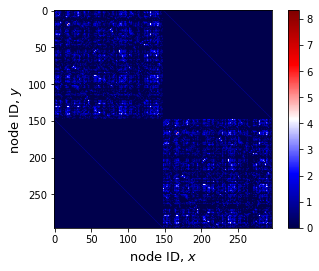

In [11]:
fig, ax = plt.subplots(1, 1)

im = ax.imshow(A, cmap = 'seismic')

ax.set_ylabel('node ID, $y$', fontsize = 13)
ax.set_xlabel('node ID, $x$', fontsize = 13)

fig.colorbar(im);

#### _Observing Edge Rankings_

In [12]:
def avg_rank(G, locs, betas):
    avg_rank = np.zeros((betas.shape[0]))

    for idx, beta in enumerate(betas):
        _, _, ranks = modified_edge_rankings(G, beta, 1)
        avg_rank[idx] = ranks[~locs].mean()
        
    return avg_rank

Now, we can observe what the rankings look like for different $\beta$ for our original graph.  This will tell us the behavior of a multiplex network depending on $\omega$ as well.

In [14]:
betas = np.logspace(-3, 0.25, 31)

In [15]:
min_omega = np.log10(0.05)
max_omega = np.log10(5)

In [16]:
omegas = np.logspace(min_omega, max_omega, 11).round(10)

rank_array = np.zeros((omegas.shape[0], betas.shape[0]))

for idx, omega in enumerate(omegas):
    print(idx, end = '\r')
    A1, _ = brain_multiplex(layer_1[brain_idx], layer_2[brain_idx], omega)
    edges1 = get_edges(A1)
    locs1 = get_edge_type(_, edges1)
    
    rank_array[idx] = avg_rank(A1, locs1.astype(bool), betas)

Here are just some minor things, for coloring purposes:

In [17]:
cmap = plt.cm.seismic

In [18]:
line_colors = [cmap(20*i) for i in range(omegas.shape[0])]

Note that we should also look at a toy model multiplex graph for similar $p_{in}$ to that of the brain network we're working on.  Notably, the brain network is weighted and this is unweighted.

In [19]:
N = A.shape[0]//2
M = get_edges((one_hot @ one_hot.T) * A1).shape[0]

In [20]:
toyranks_array = np.zeros((omegas.shape[0], betas.shape[0]))

for idx, omega in enumerate(omegas):
    print(idx, end = '\r')
    A2, one_hot2 = Multilayer(N, M, 2, omega)
    edges2 = get_edges(A2)

    locs2 = get_edge_type(one_hot2, edges2)
    
    toyranks_array[idx] = avg_rank(A2, locs2.astype(bool), betas)

In [21]:
save = False

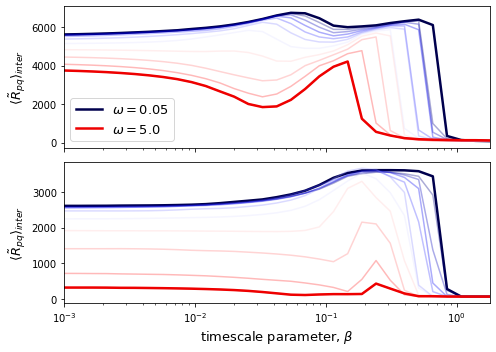

In [22]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (7, 5))

ax1, ax2 = axs

ax1.semilogx(betas, rank_array.T[:, 0], lw = 2.5, color = line_colors[0], label = r'$\omega = $' + str(omegas[0]))

for idx, line in enumerate(rank_array.T[:, 1:].T):
    ax1.semilogx(betas, line, color = line_colors[idx + 1], alpha = 0.33)

ax1.semilogx(betas, rank_array.T[:, -1], lw = 2.5, color = line_colors[-1], label = r'$\omega = $' + str(omegas[-1]))

ax1.legend(loc = 'lower left', fontsize = 13)
ax1.set_xlim(betas[0], betas[-1])
#ax1.set_xlabel(r'time scale parameter $\beta$', fontsize = 13)
ax1.set_ylabel(r'$\langle \tilde R_{pq}\rangle_{inter}$', fontsize = 13)


ax2.semilogx(betas, toyranks_array.T[:, 0], lw = 2.5, color = line_colors[0], label = r'$\omega = $' + str(omegas[0]))

for idx, line in enumerate(toyranks_array.T[:, 1:].T):
    ax2.semilogx(betas, line, color = line_colors[idx + 1], alpha = 0.33)

ax2.semilogx(betas, toyranks_array.T[:, -1], lw = 2.5, color = line_colors[-1], label = r'$\omega = $' + str(omegas[-1]))

ax2.set_xlim(betas[0], betas[-1])
ax2.set_xlabel(r'timescale parameter, $\beta$', fontsize = 13)
ax2.set_ylabel(r'$\langle \tilde R_{pq}\rangle_{inter}$', fontsize = 13)
fig.tight_layout()

if save == True:
    fig.savefig('figs/brain_multiplex.pdf')

#### _Additional Plots_

There are other things we can observe, like the weight distribution for the layers:

In [23]:
def norm_hist(vals, ax, color, label, alpha = 0.50):
    W = np.ones_like(vals)/float(len(vals))
    ax.hist(vals, weights = W, color = color, label = label, bins = 100, alpha = alpha)

In [24]:
delta_1 = A1[:N, :N]
delta_1 = np.triu(delta_1)
delta_1 = delta_1.flatten()
delta_1 = delta_1[delta_1 > 0]

In [25]:
theta_1 = A1[N:, N:]
theta_1 = np.triu(theta_1)
theta_1 = theta_1.flatten()
theta_1 = theta_1[theta_1 > 0]

We can also look at individual brain curves to verify that we didn't cherrypick one over the other.  We'll use $\omega = 1$ since that ends up being our near minimum edge weight, anyway.

In [27]:
brain_ranks = np.zeros((len(layer_1), betas.shape[0]))

for idx, _ in enumerate(layer_1):
    print(idx, end = '\r')
    Ax, _ = brain_multiplex(layer_1[idx], layer_2[idx], 1)
    
    edgesx = get_edges(Ax)
    locsx = get_edge_type(_, edgesx)
    
    brain_ranks[idx] = avg_rank(Ax, locsx.astype(bool), betas)

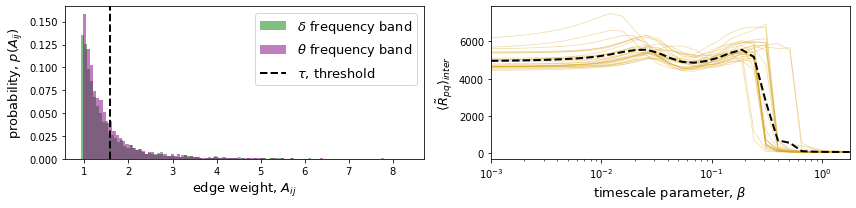

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (12, 3))

ax2, ax1 = axs

ax1.semilogx(betas, brain_ranks.T, c = 'goldenrod', alpha = 0.4, lw = 0.75)
ax1.semilogx(betas, brain_ranks.mean(axis = 0), c = 'black', lw = 2, ls = '--', label = 'Mean')
ax1.set_xlim(betas[0], betas[-1])

ax1.set_xlabel(r'timescale parameter, $\beta$', fontsize = 13)
ax1.set_ylabel(r'$\langle \tilde{R}_{pq}\rangle_{inter}$', fontsize = 13)


norm_hist(delta_1, ax2, 'green', r'$\delta$ frequency band')
norm_hist(theta_1, ax2, 'purple', r'$\theta$ frequency band')

ax2.set_ylabel('probability, $p(A_{ij})$', fontsize = 13)
ax2.set_xlabel(r'edge weight, $A_{ij}$', fontsize = 13)
ax2.axvline(theta_1.mean(), lw = 2, ls = '--', c = 'k', label = r'$\tau$, threshold')
ax2.legend(loc = 'upper right', fontsize = 13)

fig.tight_layout()
if save == True:
    fig.savefig('figs/brain_appendix.pdf')